In [1]:
import sys, os
import numpy as np
import time
from tqdm import tqdm
import onnxruntime
# import pycuda.driver as cuda
import torch

# try:
#     import pycuda.autoprimaryctx
# except ModuleNotFoundError:
#     import pycuda.autoinit

# print ("")
# print ("VERSIONS")
# print("pycuda:",pycuda.VERSION_TEXT)
# print("cuda version:",cuda.get_version())
# print("cuda driver version:",cuda.get_driver_version())
# print ("")

In [2]:
from pykitPIV import Particle, FlowField, Motion, Image

In [3]:
class ONNXmodel:
    
    def __init__(self,ONNX_FILE_PATH):
        
        self.name = "ONNX"
        # self.providers = ['CUDAExecutionProvider', 'CPUExecutionProvider']
        self.providers = ['CPUExecutionProvider']
        self.session = onnxruntime.InferenceSession(ONNX_FILE_PATH, 
                                                    None,
                                                    providers=self.providers)
        
        # get the name of the first input of the model
        self.input_name = self.session.get_inputs()[0].name  
        print('Input Name:', self.input_name)   
 
    def inference(self,x):
        
        output = self.session.run([], {self.input_name:x})[0] 
        output = output[0,:,:,:]
        
        return output

    def test(self,x,target):
        
        y = self.inference(x)
        
        return y

    def empty(self):
        
         with torch.no_grad():
            torch.cuda.empty_cache()

In [4]:
model_file='Lima_L4_PAD_SR2_dyn.onnx'
print("model:",model_file,'  exist:',os.path.exists(model_file))

model: Lima_L4_PAD_SR2_dyn.onnx   exist: True


In [5]:
lima_model = ONNXmodel(model_file)

Input Name: Input


In [6]:
lima_model

## Create sample images for the LIMA model

In [7]:
particles = Particle(1, 
                     size=(256,256), 
                     size_buffer=10,
                     diameters=(2, 2),
                     densities=(0.2, 0.2),
                     diameter_std=0,
                     random_seed=100)

flowfield = FlowField(1,
                      size=(256,256),
                      size_buffer=10,
                      random_seed=100)

flowfield.generate_random_velocity_field(gaussian_filters=(4, 4),
                                         n_gaussian_filter_iter=20,
                                         displacement=(4, 4))


motion = Motion(particles,
                flowfield,
                time_separation=1,
                particle_loss=(0, 0))

motion.runge_kutta_4th(n_steps=20)

image = Image(random_seed=100)

image.add_particles(particles)
image.add_flowfield(flowfield)
image.add_motion(motion)
image.add_reflected_light(exposures=(0.9, 0.9),
                          maximum_intensity=2**16-1,
                          laser_beam_thickness=2,
                          laser_beam_shape=0.9,
                          alpha=1/8)

images_I1 = image.remove_buffers(image.images_I1)
images_I2 = image.remove_buffers(image.images_I2)

images_tensor = image.concatenate_tensors((images_I1, images_I2))

targets_tensor = image.remove_buffers(image.get_displacement_field())

tensors_dictionary = {"I"      : images_tensor, 
                      "target" : targets_tensor}

Particles added to the image.
Velocity field added to the image.
Particle movement added to the image.
Reflected light added to images I1.
Reflected light added to images I2.


In [8]:
import matplotlib.pyplot as plt

In [9]:
img = images_tensor[0,:,:,:].astype(np.float32)/np.max(images_tensor[0,:,:,:])

In [10]:
pred = lima_model.inference(img)

In [11]:
which_component = 0

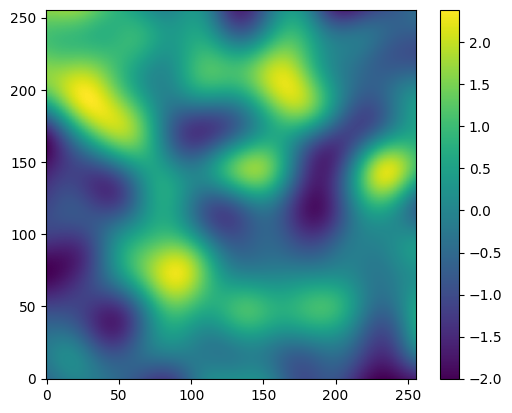

In [12]:
plt.imshow(targets_tensor[0,which_component,:,:], origin='lower')
plt.colorbar()

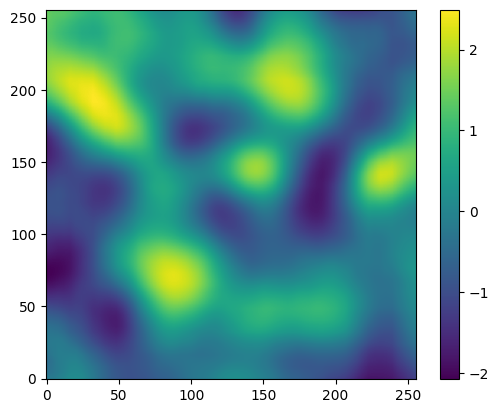

In [13]:
plt.imshow(pred[which_component,:,:], origin='lower')
plt.colorbar()

***